## Overview

* Strava (www.strava.com) is a social network for tracking workouts, e.g. running, swimming, biking, skiing, etc. 
* It has many linked applications that give it a robust array of data sources. 
* The data consists of position from GPS and baro altimeters, and lots of sensor data including:
    * Heartrate
    * Cadence
    * Power/Watts
    * Speed
    * Temperature
    
* The open API has many different flavors including a Python backend: https://github.com/hozn/stravalib
* They also have a showcase of applications using their API: https://labs.strava.com, https://labs.strava.com/projects/
* I use the heatmap whenever I go to a new city to see the best places to run: https://labs.strava.com/heatmap

In [1]:
import IPython
url = 'https://labs.strava.com/heatmap/'
iframe = '<iframe src=' + url + ' width=1200 height=800></iframe>'
IPython.display.HTML(iframe)

The data on Strava is usually plotted against time with some forms of aggregation, and for premium users ($59/year) you can see estimates on how in shape you are. Being a data guy I wanted to know more. I wanted to see relationships, trends, patterns, and distributions. I had a pretty rough marathon trying to qualify for Boston last year and found a good paper describing the effect of temperature on marathon performance.
http://www.physiology.org/doi/full/10.1152/japplphysiol.00367.2010#

Below I'll go through my data and look for various things using Python's Bokeh, Holoviews, and Datashaders. I go through both my activites and specific stream data as well. At the end I try and evaluate the marathon above and where things wen't wrong...

# General Activity Viz
This data was pulled using the other folder within this package. If you have an App on Strava already it's easy to get a client ID and pull your data down. The Strava data throttling will mean you need to keep running it until all your data is pulled down. It saves the general activity info in a .csv file and the stream data (second by second data) in an h5 file.

In [2]:
%config IPCompleter.greedy=True
import pandas as pd

In [3]:
act_df = pd.read_csv('activities_cleaned.csv')
act_df.start_date_local = pd.to_datetime(act_df.start_date_local)
act_df = act_df.set_index('start_date_local')
act_df['month'] = act_df.index.map(lambda x: x.month)
act_df['year'] = act_df.index.map(lambda x: x.year)
act_df['season'] = (act_df['month']+2)//3

## Kudos Viz
Full disclaimer I don't care about getting Kudos but thought this was fun. Plot of rolling average of Kudos over time and Kudo's vs pace to see if there is a relationship between how fast I run and how many Kudos I get.

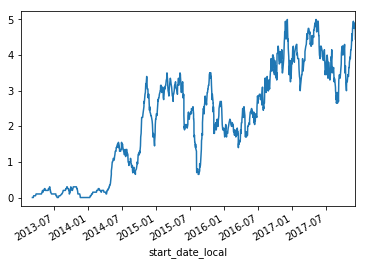

In [4]:
%matplotlib inline
act_df[(act_df['type']=='Run') & (act_df['year'] > 2012)].kudos_count.rolling(20).mean().plot()

In [5]:
temp_df = act_df[act_df['type']=='Run']
temp_df = temp_df[temp_df.kudos_count>0]
temp_df['pace'] = 1/(temp_df.average_speed*0.0372823)
temp_df = temp_df[temp_df.pace < 10]

-0.13601021629563464

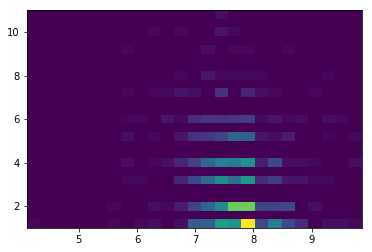

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
#pace[pd.np.isnan(pace)]
blah = plt.hist2d(temp_df.pace.values, temp_df.kudos_count.astype(float),bins=25)
temp_df.pace.corr(temp_df.kudos_count)

Looks like there is more correlation between distance than pace (0.42 vs 0.13)

0.42984337510888088

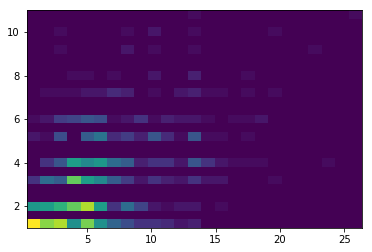

In [7]:
blah = plt.hist2d(temp_df.distance.values, temp_df.kudos_count.astype(float),bins=25)
temp_df.distance.corr(temp_df.kudos_count)

# Heartrate Viz
Now we'll do a similiar analysis on Heartrate.

In [8]:
temp_df = act_df[act_df['type']=='Run']
temp_df = temp_df[pd.notnull(temp_df.average_heartrate)]
temp_df['pace'] = 1/(temp_df.average_speed.astype(float)*0.0372823)
temp_df = temp_df[temp_df.pace < 10]

-0.54323364707559518

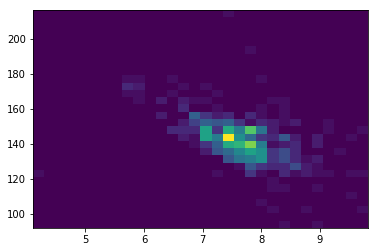

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
#pace[pd.np.isnan(pace)]
blah = plt.hist2d(temp_df.pace.values, temp_df.average_heartrate.astype(float),bins=30)
temp_df.pace.corr(temp_df.average_heartrate)

0.084367356529157694

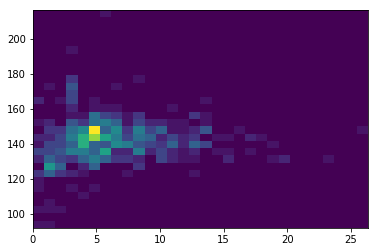

In [10]:
blah = plt.hist2d(temp_df.distance.values, temp_df.average_heartrate.astype(float),bins=30)
temp_df.distance.corr(temp_df.average_heartrate)

# Seaborn
Other Python packages exist to make viewing the data a little cleaner. Seaborn provies a PairPlot option that makes this pretty straightforward with a lot of cool built-ins.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [12]:
temp_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'achievement_count', 'athlete_count',
       'average_cadence', 'average_heartrate', 'average_speed', 'average_temp',
       'average_watts', 'best_efforts', 'calories', 'comment_count', 'commute',
       'description', 'device_name', 'device_watts', 'distance',
       'elapsed_time', 'elev_high', 'elev_low', 'embed_token', 'external_id',
       'flagged', 'gear', 'gear_id', 'guid', 'has_heartrate', 'has_kudoed',
       'id', 'instagram_primary_photo', 'kilojoules', 'kudos_count',
       'location_city', 'location_country', 'location_state', 'manual',
       'max_heartrate', 'max_speed', 'max_watts', 'moving_time', 'name',
       'partner_brand_tag', 'partner_logo_url', 'photo_count', 'photos',
       'pr_count', 'private', 'resource_state', 'segment_efforts',
       'splits_metric', 'splits_standard', 'start_date', 'start_latitude',
       'start_longitude', 'suffer_score', 'timezone', 'total_elevation_gain',
       'total_photo_count', 'trainer', 

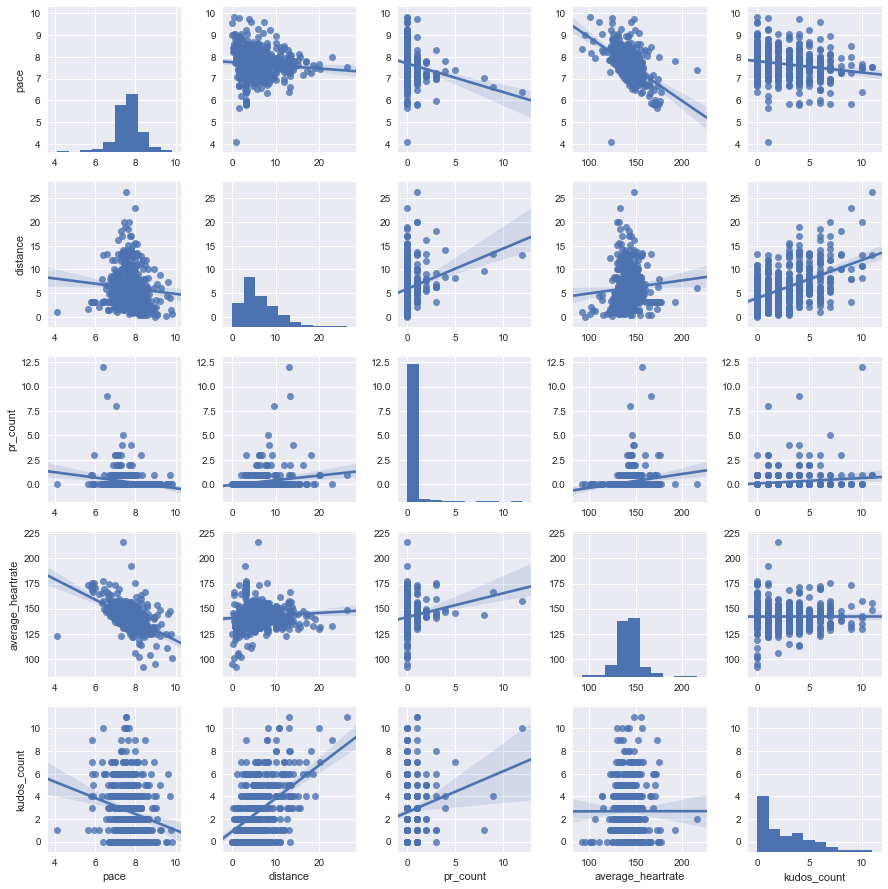

In [13]:
%matplotlib inline
g = sns.pairplot(temp_df[['pace','distance','pr_count','average_heartrate','kudos_count']].dropna(), kind="reg",dropna=True)

There is a lot going on in this plot. The diagonal is all of the histograms for each set of data and the off-axis are the relationships. You can quickly see all the relationships between all the data sets. The same individal plots we did above are evident here.

# Biking Plots

In [14]:
bike_df = act_df[(act_df['type']=='Ride') | (act_df['type']=='VirtualRide')]
bike_df = bike_df[pd.notnull(bike_df.average_heartrate)]
bike_df['average_speed'] = bike_df['average_speed']*3600/1609

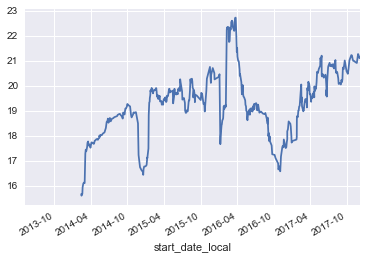

In [15]:
bike_df.average_speed.rolling(15).mean().plot()

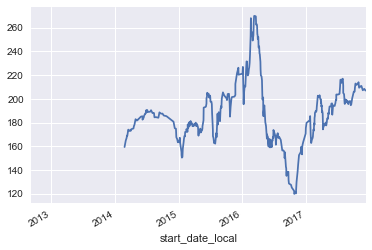

In [16]:
bike_df = act_df[(act_df['type']=='Ride') | (act_df['type']=='VirtualRide')]
bike_df = bike_df[pd.notnull(bike_df.average_watts)]
bike_df.average_watts.rolling(20).mean().plot()

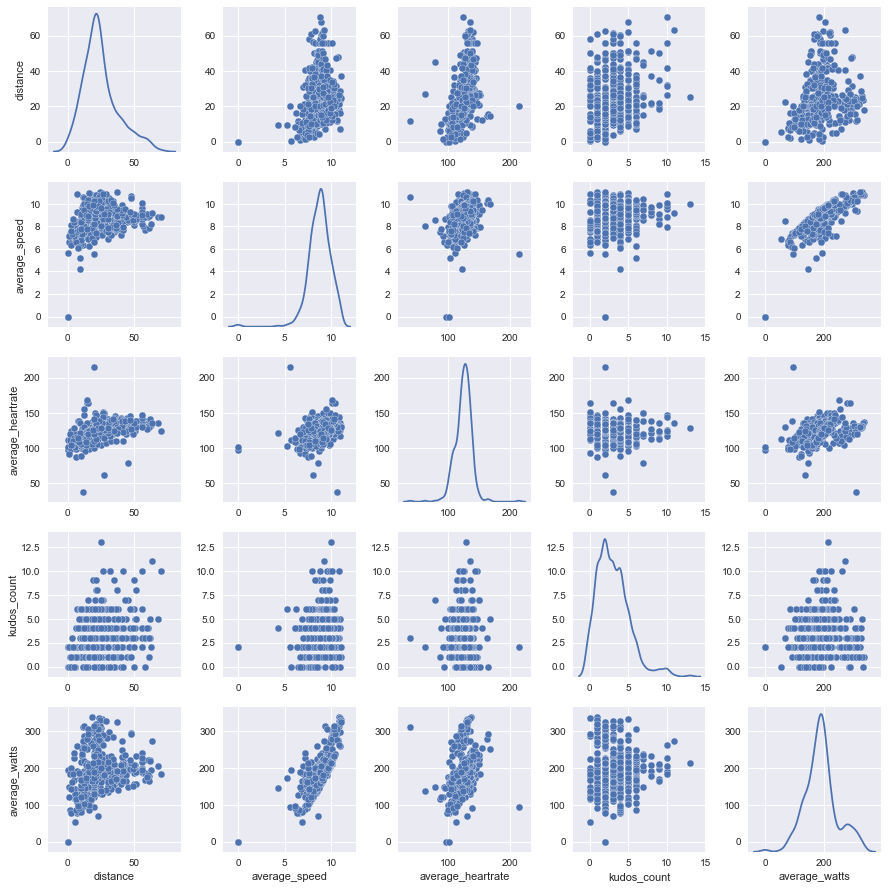

In [17]:
g = sns.pairplot(bike_df[['distance','average_speed','average_heartrate','kudos_count','average_watts']].dropna(), diag_kind="kde",dropna=True)

# Swimming Plots

In [18]:
swim_df = act_df[(act_df['type']=='Swim')]
swim_df = swim_df[swim_df.average_speed > 0]
swim_df['100yd_pace'] = 1/swim_df.average_speed/60*100*0.914

In swimming the 100 yard/meter pace is a typical way of describing speed/pace. The following plot shows my swimming improvement over time. 

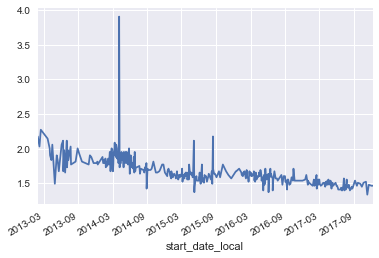

In [19]:
swim_df['100yd_pace'].plot()

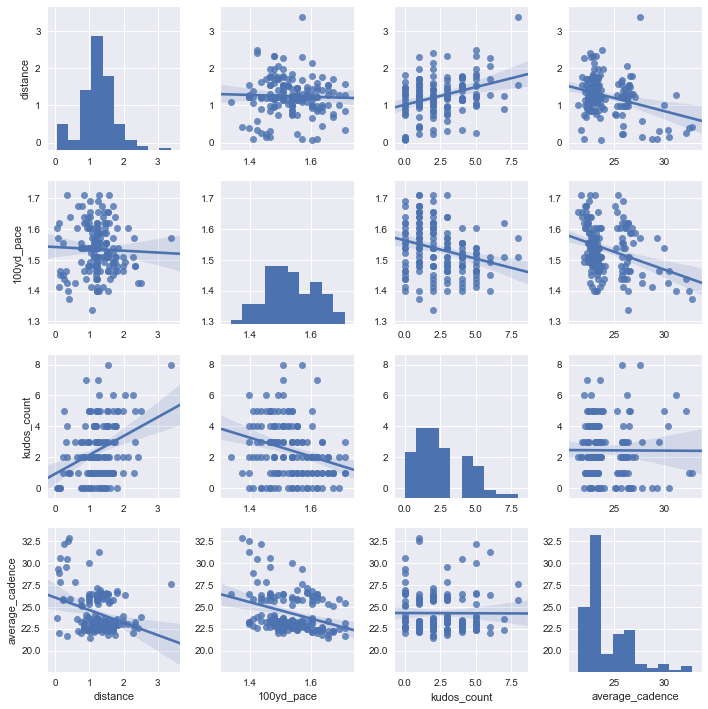

In [20]:
g = sns.pairplot(swim_df[['distance','100yd_pace','kudos_count','average_cadence']].dropna(), kind="reg",dropna=True)

# HoloViews
HoloViews is another way of plotting with a little more built in interaction.


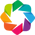

In [21]:
import holoviews as hv
from holoviews.operation import gridmatrix
hv.extension('bokeh', 'matplotlib', width="75")

In [41]:
%%opts Overlay [width=300 height=300 show_frame=False]
%%opts Bivariate [bandwidth=0.5] (cmap='Blues') Points (size=2)
%%opts Points    [tools=['box_select']]

temp_df = act_df[act_df['type']=='Run']
temp_df = temp_df[pd.notnull(temp_df.average_heartrate)]
temp_df['pace'] = 1/(temp_df.average_speed.astype(float)*0.0372823)
temp_df = temp_df[temp_df.pace < 10]
temp_df = temp_df[pd.notnull(temp_df.average_heartrate)]
act_ds = hv.Dataset(temp_df[['pace','distance','average_heartrate']].dropna())

density_grid = gridmatrix(act_ds, diagonal_type=hv.Distribution, chart_type=hv.Bivariate)
point_grid = gridmatrix(act_ds, chart_type=hv.Points)

density_grid * point_grid

:GridMatrix   [X,Y]
   :Overlay
      .Distribution.I :Distribution   [pace]   (Density)
      .Histogram.I    :Histogram   [pace]   (pace_frequency)

This is a test to see if my heartrate/pace change from year to year and season to season. You can set the slider to a season and then scroll through the years to see the relationships.

In [23]:
%%opts Overlay [width=700 height=400 show_frame=False]
%%opts Curve (color='k') Scatter [color_index=2 size_index=2 scaling_factor=1.4] (cmap='Blues' line_color='k')
%%opts VLine (color='k' line_width=1)
%%opts Text (text_font_size='13px')
temp_df = temp_df[temp_df['year'] > 2012]
macro = hv.Table(temp_df, ['pace','average_heartrate','season','year'], [])
curves = macro.to.spikes('average_heartrate', ['pace'])
scatter = macro.to.scatter('average_heartrate', ['pace', 'season','year'])
curves * scatter

:HoloMap   [season,year]
   :Overlay
      .Spikes.I  :Spikes   [average_heartrate]   (pace)
      .Scatter.I :Scatter   [average_heartrate]   (pace,season,year)

In [24]:
with pd.HDFStore('streams.h5','r') as store:
    all_df = store.select('streams',columns=['time','distance','velocity_smooth','lat','lon','heartrate','id'])
#get rid of times greater than 24 hours...or 86400 seconds
df = all_df[all_df['time'] < 86400]
df = df[(pd.notnull(df['lon'])) & (pd.notnull(df['lat']))]

In [25]:
import numexpr as ne
# source: http://www.neercartography.com/latitudelongitude-tofrom-web-mercator/
def toWebMercator(xLon, yLat):
    semimajorAxis = 6378137.0  # WGS84 spheriod semimajor axis
    east = ne.evaluate("xLon * 0.017453292519943295")
    north = ne.evaluate("yLat * 0.017453292519943295")
 
    northing = ne.evaluate("3189068.5 * log((1.0 + sin(north)) / (1.0 - sin(north)))")
    easting = ne.evaluate("semimajorAxis * east")
 
    return easting, northing


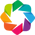

In [26]:
import holoviews as hv
import geoviews as gv
import cartopy.crs as ccrs
import pandas as pd
from bokeh.tile_providers import STAMEN_TONER
from bokeh.models import WMTSTileSource
from holoviews.operation.datashader import aggregate

hv.extension('bokeh')

tiles = {'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'),
         'ESRI': WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'),
         'Wikipedia': WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
         'Stamen Toner': STAMEN_TONER}

In [27]:
df['x'],df['y'] = toWebMercator(df['lon'],df['lat'])

In [28]:
%%opts Overlay [width=1024 height=600] 
%%opts Points (size=0.05 cmap='viridis') [tools=['hover'] size_index=2 color_index=2 xaxis=None yaxis=None]
from holoviews.operation.datashader import aggregate, shade, datashade, dynspread
from holoviews.operation import decimate
data = gv.Dataset(df, kdims=['heartrate', 'velocity_smooth'])
points = data.to(gv.Points, kdims=['x', 'y'], vdims=['heartrate', 'velocity_smooth'], crs=ccrs.PlateCarree())
dynspread(datashade(points)) * gv.WMTS(tiles['Wikipedia'])

C:\tmp\test3\strava_data_viz\lib\site-packages\holoviews\operation\datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:


:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [x,y]   (R,G,B,A)
      .WMTS.I :WMTS   [Longitude,Latitude]

# Last setup is my Boston Qualify Fail from 2017
It litterally snowed the week before and was in the 70s during the marathon

In [29]:
url ='http://www.physiology.org/na101/home/literatum/publisher/physio/journals/content/jappl/2010/jappl.2010.109.issue-6/japplphysiol.00367.2010/production/images/medium/zdg0101092610001.jpeg'
iframe = '<iframe src=' + url + ' width=700 height=400></iframe>'
IPython.display.HTML(iframe)

In [30]:
mar_df = all_df[all_df.id == 831769216]
mar_df = mar_df.set_index('time')

C:\tmp\test3\strava_data_viz\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


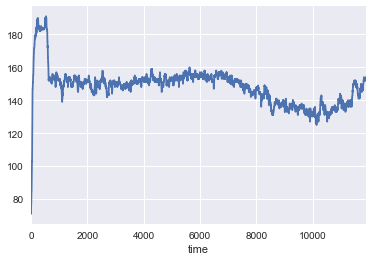

In [31]:
mar_df['pace'] = 1/(mar_df['velocity_smooth']*0.0372823)
mar_df['pace'][mar_df['pace'].isnull()] = 0
mar_df['heartrate'].plot()

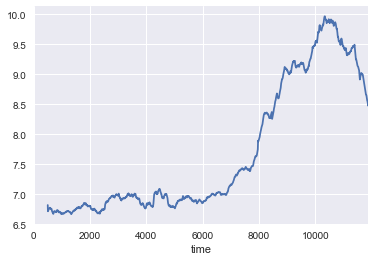

In [32]:
mar_df['pace'].rolling(500).mean().plot()

In [33]:
#pulled from here: https://www.wunderground.com/history/airport/KWRB/2017/1/14/DailyHistory.html
temperatureF = pd.Series([46.6,51.8,58.3,66.4,73.2],index=[-20,40,100,160,240]) #race started at 8:20, this is the first time
temperatureF.index = temperatureF.index*60 #to seconds
temperatureC = (temperatureF-32)*5/9

In [35]:
#inteprolate temperature into this dataframe
mar_df['temp'] = pd.np.nan
temp = pd.concat([mar_df['temp'], temperatureC]).sort_index().interpolate()
mar_df['temp'] = temp[~temp.index.duplicated(keep='first')].reindex(mar_df['temp'].index)

In [36]:
ra_mar_df = mar_df.rolling(100).mean()

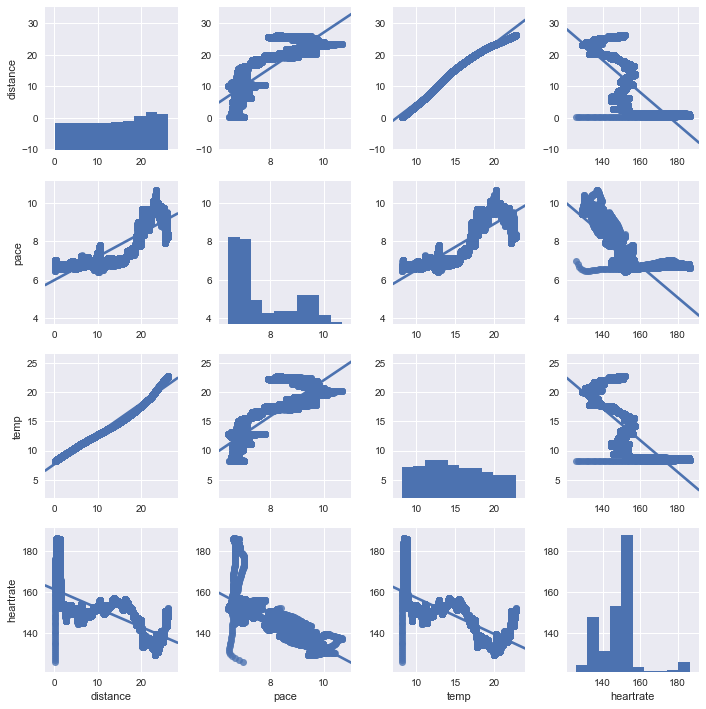

In [37]:
g = sns.pairplot(ra_mar_df[['distance','pace','temp','heartrate']].dropna(), kind="reg",dropna=True)

Really want a plot of performance over time to see how well it maps to results from the paper above. Since performance isn't something we can directly measure, this is an attempt to come up with some metric of performance. Heart rate alone may be a good metric and pace alone may be, but they are a function of performance _and_ effort. I may have started giving up at the end and it would look like performance dropped but really it could have been effort. Normalizing heartate with pace is a good indication of performance. Even if effort went down heartrate and pace would go down together...unless there was an effect of performance. Then their relationship would start to change. If their relationshp isn't linear though it would be hard, this non-linearization might skew this plot as well. The plot below shows this effect.

(<matplotlib.axes._subplots.AxesSubplot at 0x27504a5bf98>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27504a5bf98>)

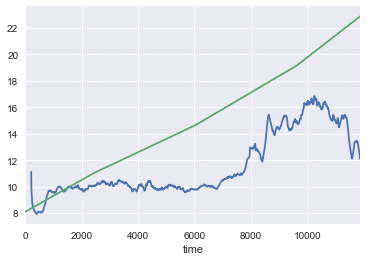

In [38]:
(220/(mar_df['heartrate']/mar_df['pace'])).rolling(200).mean().plot(), mar_df['temp'].plot()